# 機械学習 第7回：LDA(Linear Discriminant Analysis)

引用サイト
https://ameblo.jp/cognitive-solution/entry-12287355673.html

最初にLDAを公式化したR. A. Fisherにちなんで、フィッシャーのLDAと呼ぼれることもあります。LDAを適用するにあたり、データが以下の3つの条件を満たしていることを前提にしています。

1. データが正規分布している。
1. 各クラスが同じ共分散行列を持つ。
1. 変量が統計的に互いに独立している。
 

使用するデータは、前回(第6回)と同様に、オープンソースであるUCI機械学習リポジトリから、「ワインデータ」を使用します。178のデータからなり、変数は、'Alcohol', 'Malic acid', 'Ash', 'Alcalinity of ash', 'Magnesium', 'Total phenols', 'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins', 'Color intensity', 'Hue', 'OD280/OD315 of diluted wines', 'Proline'の化学特性による13の変量からなります。

 

https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data

 

各サンプルは、３つの異なるクラス(1または 2またh 3)に属します。それぞれ、イタリアの異なる地域で栽培された異なるぶどうのタイプを表しています。

13の変量がありますが、２次元の図にプロットする都合上、LDAにより、２つの新変量を抽出し、Pythonを使用してワインの種類を予測する機械学習モデルを作成します。LDAとPythonを使用した機械学習の流れは、概ね以下になります。主成分分析の場合と異なるのは7と8のみです。なお、Pythonのバージョンは3.5以上を想定しています。

 

プロット出力用の関数を定義する。
データを入力する。
入力データを、トレーニングデータとテストデータに分ける。
トレーニングデータを使用してデータの標準偏差と平均値を求める。
標準偏差と平均値を使用して、トレーニングデータとテストデータを、それぞれ標準化する。
適切なモデル(Classifier)を選択する。
LDAにより、入力データから上位２つの新変量を抽出する。
LDAにより抽出されたトレーニングデータを使用して、モデルに機械学習させる。
テストデータを使用して、ラベルの分類を行い、モデルを評価する。
学習結果を図にプロットする。
では、各ステップを詳しく見ていきましょう。

## ① プロット出力用の関数を定義する。

「plot_decision_regions」という名前のプロット出力用の関数を定義します。

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

def plot_decision_regions(X, y, classifier, resolution=0.02):
    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                         np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # plot class samples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],
                    alpha=0.8, c=cmap(idx),
                    marker=markers[idx], label=cl)

## ② データを入力する。

今回は、冒頭でご紹介した「ワインデータ」を、オープンソースとして提供しているサイトのURLから、pandasライブラリーを使用して以下のようにデータを抽出します。変量Xの配列(178 x 13)に、ラベル(ワインの種類)を y(178x 1)という配列に178サンプル分のデータを格納します。

In [17]:
import pandas as pd
df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data', header=None)

X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values

## ③ 入力データを、トレーニングデータとテストデータに分ける。

scikit-learning.model_selectionライブラリーのtrain_test_split関数を使用して、変量配列Xとラベル配列yについて、トレーニングデータとテストデータに分けます。変量配列Xを、それぞれ、X_train配列, X_test配列に分割し、ラベル配列yは、y_tarin配列, y_test配列へそれぞれ分割します。test_sizeのパラメータにより、テストデータの割合を指定できます。ここでは、0.3を指定することで、テストデータの割合を全体の30%と指定しています。全178サンプルの30%（= 53サンプル）がテストデータで、残りの125サンプルがトレーニングデータとなります。random_state=0を指定することにより、ランダムにトレーニングデータとテストデータを分割することができます。

In [18]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=0)

## ④ トレーニングデータを使用してデータの標準偏差と平均値を求める。

sklearn.preprocessingライブラリーのStandardScaler関数を用いて、変量配列X_trainとX_testを標準化します。まず、標準化のための標準偏差と平均値は、トレーニングデータのみを使用して計算しなければなりません。fitメソッドを使用して以下のように行います。

In [19]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(X_train)

StandardScaler()

## ⑤ 標準偏差と平均値を使用して、トレーニングデータとテストデータを、それぞれ標準化する。

次に、変量配列のトレーニングデータとテストデータを、transformメソッドを用いて、それぞれ標準化します。標準化した変量配列をそれぞれ、X_train_std, X_test_stdに格納します。

In [20]:
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

## ⑥ 適切なモデル(Classifier)を選択する。

様々なClassifierがPythonライブラーの中でサポートされています。線形データとして分類できる場合は、Perceptron, Adaptive Linear Neuron(Adaline),Logistic regulation, Support Vector Machine(SVM),Decision tree, Random forests, K-nearest neighbors(KNN)などがあります。主成分分析の場合と比較するために、第6回で選択した、Logistic regulationをここでも選択することにいたします。sklearn.linear_modelライブラリーのLogisticRegression関数を使用して以下のように記述します。

In [28]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()

Logistic Regressionにご興味のある方は、以下の本の第3章を是非、読んでみてください。

「Python Machine Learning: Unlock Deeper Insights into Machine Learning With This Vital Guide to Cutting-edge Predictive Analytics」

Sebastian Raschka (著)

出版社: Packt Publishing (2015/9/23)

言語: 英語

ISBN-10: 1783555130

ISBN-13: 978-1783555130

## ⑦ LDAにより、入力データから上位２つの新変量を抽出する。

sklearn.discriminant_analysisライブラリーの中でサポートされている LinearDiscriminantAnalysis関数を用いて、トレーニングデータについてLDA分析を行い、トレーニングデータ及びテストデータについて、２つの新変量を抽出します。

In [27]:
from sklearn.discriminant_analysis import  LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis(n_components=2)

X_train_lda = lda.fit_transform(X_train_std,y_train)
X_test_lda = lda.transform(X_test_std)

## ⑧ LDAにより抽出されたトレーニングデータを使用して、モデルに機械学習させる。

トレーニングデータにfitメソッドを適用して、学習させます。

In [23]:
lr.fit(X_train_lda, y_train)

LogisticRegression()

## ⑨ テストデータを使用して、ラベルの分類を行い、モデルを評価する。

テストデータを使用して、ラベルの分類を行い、sklearn.metricsライブラリーのaccuracy_score関数を用いて、モデルの精度を評価します。

In [24]:
from sklearn.metrics import accuracy_score

y_pred = lr.predict(X_test_lda)
print('Accuracy: %.2f' % accuracy_score(y_test,y_pred))

Accuracy: 1.00


出力結果は、100%の精度と表示されます。

## ⑩ 学習結果を図にプロットする。

①で定義したplot_decision_regions関数を用いて、トレーニングデータとテストデータについて、それぞれ、抽出した第1新変量(LD1)を横軸に、第２新変量1(LD2)を縦軸にした２次元領域にプロットします。

まず、トレーニングデータについてプロットします。

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


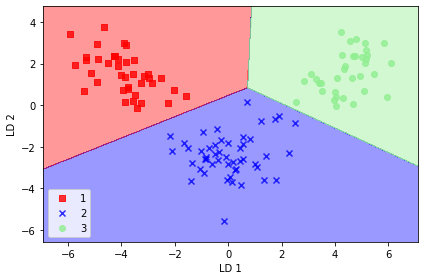

In [25]:
plot_decision_regions(X_train_lda, y_train, classifier=lr)

plt.xlabel('LD 1')

plt.ylabel('LD 2')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

トレーニングデータについて、概ね、直線で、分類されていることがわかります。

次に、テストデータについてプロットします。

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


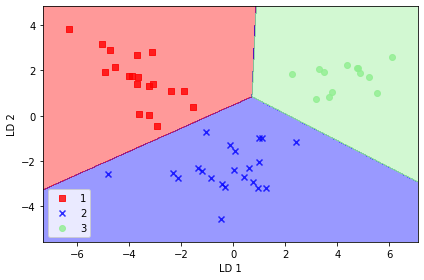

In [26]:
plot_decision_regions(X_test_lda, y_test, classifier=lr)

plt.xlabel('LD 1')

plt.ylabel('LD 2') 
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

テストデータについては、全てのサンプルが直線で３つの領域に分類できていることがわかります。